In [1]:
# Load libraries
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy.stats
import statsmodels.api as sm

In [2]:
# Open yvr_listing_data.csv in the data folder
listings_df = pd.read_csv(os.path.join('data', 'yvr_listing_data.csv'))

# Print columns
# print(listings_df.columns)

# Select columns that are completly textual description or apparently non-related to legality(including coordinates).

excluded_columns = ['listing_url','scrape_id', 'last_scraped', 'source', 
                       'name','description', 'neighborhood_overview', 'picture_url', 
                       'host_id', 'host_url', 'host_name', 'host_since', 
                       'host_location', 'host_about', 'host_thumbnail_url', 
                       'host_picture_url', 'latitude', 'longitude', 'calendar_updated', 
                       'calendar_last_scraped', 'amenities', 'bathrooms_text',
                       'first_review','last_review']

remained_columns = [col for col in listings_df if col not in excluded_columns]
remained_columns = list(set(remained_columns))

# Delete all textual description columns 

listings_df = listings_df[remained_columns]



In [3]:
%%capture --no-stdout
"""
Create a new column titled "legal_listing" that contains the boolean describing whether or not the listing has a valid license.
The column is True if the listing has a valid license or does not require one and False if the listing does not have a valid license.
To compute the value of the column, we use the following logic:

If the listing has a number in the "license" column with the regex pattern of r'.*?(\d{2}[-\s]?\d{6}).*?' 
OR the listing has a number in the "minimum_nights" column with a value equal to or greater than 30,
THEN the "legal_listing" is True. ELSE the "valid_license" is False.

Note:
The regex pattern r'.*?(\d{2}[-\s]?\d{6}).*?' is used to find a number with 2 digits, followed by a dash or space, 
followed by 6 digits. The number can be surrounded by any number of characters. 
TODO: Verify this is the correct pattern for the license numbers and find any other ways of verifying legitimate license numbers.
"""

###Just found there are some values like 'dd-ddd-ddd', so I changed regex pattern for better compatibility
#regex_pattern = re.compile(r'.*?(\d{2}[-\s]?\d{6}).*?')
regex_pattern = re.compile(r'.*?(\d{2}[-\s]?\d{3}[-\s]?\d{3}).*?')

# Create the valid_license column using the logic described above
listings_df['legal_listing'] = listings_df['license'].str.contains(regex_pattern) | (listings_df['minimum_nights'] >= 30)

# Create new dataframe storing values after normalization or preprocessing
listings_df_cleaned = pd.DataFrame()
listings_df_cleaned['id'] = listings_df['id']
listings_df_cleaned['legal_listing'] = listings_df['legal_listing']

# Drop the 'license' column for better processing
listings_df.drop('license',axis=1, inplace=True)


# Print only the columns we are interested in
#print(listings_df[['id', 'license', 'minimum_nights', 'legal_listing']])

# Print count of valid and invalid licenses
#print(listings_df['legal_listing'].value_counts())

Hey guys, just came up with a new assumption: As our main goal is to construct a regression model and predict a new-coming property's legality, should we neglect all of those 'post-occupancy evaluation'  fields just like 'review_score' or 'host_response_time'? Because all of those information was collected after some renter's experience, while what we are trying to do is to provide more useful information for renters before the renting contract?

And I have done some preliminary filtering and division among all columns.

In [4]:
#print(listings_df.columns)
listings_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 51 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   calculated_host_listings_count_shared_rooms   6695 non-null   int64  
 1   number_of_reviews_l30d                        6695 non-null   int64  
 2   availability_90                               6695 non-null   int64  
 3   host_verifications                            6695 non-null   object 
 4   maximum_maximum_nights                        6695 non-null   int64  
 5   review_scores_value                           5627 non-null   float64
 6   availability_365                              6695 non-null   int64  
 7   room_type                                     6695 non-null   object 
 8   review_scores_rating                          5641 non-null   float64
 9   reviews_per_month                             5641 non-null   f

**Dealing with some object column**

In [5]:
object_columns = listings_df.select_dtypes(include='object')

object_columns_name = list(object_columns.columns)
object_columns_name

['host_verifications',
 'room_type',
 'price',
 'neighbourhood_cleansed',
 'host_neighbourhood',
 'host_is_superhost',
 'host_acceptance_rate',
 'host_response_time',
 'has_availability',
 'host_identity_verified',
 'neighbourhood',
 'host_has_profile_pic',
 'host_response_rate',
 'instant_bookable',
 'property_type']

In [6]:
#converting 'price' column
# Convert price to a float variable
if listings_df['price'].dtype == 'object':
    listings_df['price'] = listings_df['price'].str.replace('$', '').str.replace(',', '').astype(float)

# Convert 'host_acceptance_rate' to a float variable
if listings_df['host_acceptance_rate'].dtype == 'object':
    listings_df['host_acceptance_rate'] = listings_df['host_acceptance_rate'].str.replace('%', '').astype('Int64')

# Convert 'host_response_rate' to a float variable
if listings_df['host_response_rate'].dtype == 'object':
    listings_df['host_response_rate'] = listings_df['host_response_rate'].str.replace('%', '').astype('Int64')
    

# Convert 'host_is_superhost' to a bool variable
if listings_df['host_is_superhost'].dtype == 'object':
    listings_df['host_is_superhost'] = listings_df['host_is_superhost'].astype('bool')

# Convert 'host_has_profile_pic' to a bool variable
if listings_df['host_has_profile_pic'].dtype == 'object':
    listings_df['host_has_profile_pic'] = listings_df['host_has_profile_pic'].astype('bool')

# Convert 'has_availability' to a bool variable
if listings_df['has_availability'].dtype == 'object':
    listings_df['has_availability'] = listings_df['has_availability'].astype('bool')

# Convert 'instant_bookable' to a bool variable
if listings_df['instant_bookable'].dtype == 'object':
    listings_df['instant_bookable'] = listings_df['instant_bookable'].astype('bool')

In [7]:
# Check the object columns again
object_columns = listings_df.select_dtypes(include='object')

object_columns_name = list(object_columns.columns)
object_columns_name

['host_verifications',
 'room_type',
 'neighbourhood_cleansed',
 'host_neighbourhood',
 'host_response_time',
 'host_identity_verified',
 'neighbourhood',
 'property_type']

**One-hot to code categorical columns**

In [8]:
for colname in object_columns_name:
    # convert room_type column to 'category' dtype
    listings_df[colname] = listings_df[colname].astype('category')
    # applying one-hot coding (drop_first means eliminate one freedom degree to prevent multicollinearity)
    one_hot_encoded = pd.get_dummies(listings_df[colname], prefix=colname, drop_first=True)
    # join new columns back to DataFrame
    listings_df = listings_df.join(one_hot_encoded)

**listing_df for VIF**

In [9]:
listings_df_VIF = listings_df.select_dtypes(include=['bool','float64','int64'])
listings_df_VIF.drop(['bathrooms', 'neighbourhood_group_cleansed'], axis=1, inplace=True)

**Using VIF to filter relating variables**

In [10]:
int64_columns = listings_df_VIF.select_dtypes(include='Int64').columns
listings_df_VIF.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Columns: 211 entries, calculated_host_listings_count_shared_rooms to property_type_Tower
dtypes: Int64(2), bool(175), float64(13), int64(21)
memory usage: 3.0 MB


In [11]:
# 假设 listings_df_VIF 是你的DataFrame
columns_Int64 = [col for col in listings_df_VIF.columns if pd.api.types.is_integer_dtype(listings_df_VIF[col]) and listings_df_VIF[col].dtype.name == 'Int64']

print(columns_Int64)


['host_acceptance_rate', 'host_response_rate']


In [12]:
listings_df_VIF['host_response_rate']=listings_df_VIF['host_response_rate'].astype(float)
listings_df_VIF['host_acceptance_rate']=listings_df_VIF['host_acceptance_rate'].astype(float)

In [13]:

listings_df_VIF = listings_df_VIF.astype('float64')

In [16]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

# Drop all rows containing NAs or infs in listings_df_VIF


listings_df_VIF.replace([np.inf, -np.inf], np.nan, inplace=True)
listings_df_VIF.dropna(inplace=True)
df_with_const = add_constant(listings_df_VIF,has_constant='add')

In [15]:
help(add_constant)

Help on function add_constant in module statsmodels.tools.tools:

add_constant(data, prepend=True, has_constant='skip')
    Add a column of ones to an array.
    
    Parameters
    ----------
    data : array_like
        A column-ordered design matrix.
    prepend : bool
        If true, the constant is in the first column.  Else the constant is
        appended (last column).
    has_constant : str {'raise', 'add', 'skip'}
        Behavior if ``data`` already has a constant. The default will return
        data without adding another constant. If 'raise', will raise an
        error if any column has a constant value. Using 'add' will add a
        column of 1s if a constant column is present.
    
    Returns
    -------
    array_like
        The original values with a constant (column of ones) as the first or
        last column. Returned value type depends on input type.
    
    Notes
    -----
    When the input is a pandas Series or DataFrame, the added column's name
    is '

In [19]:


def drop_column_using_vif_(df, thresh=2):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df,has_constant='add')

        if 'const' in df_with_const.columns:
            vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) for i in range(df_with_const.shape[1])], name= "VIF", 
                                index=df_with_const.columns).to_frame()

            # drop the const
            vif_df = vif_df.drop('const')
        else:
            raise ValueError("constant column 'const' not successfully added")
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

***VIF***

In [20]:
listings_df_VIF_new = drop_column_using_vif_(listings_df_VIF.drop('legal_listing', axis=1))

c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: maximum_nights_avg_ntm


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: minimum_maximum_nights


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: id


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: calculated_host_listings_count_shared_rooms


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: room_type_Hotel room


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: room_type_Private room


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping: property_type_Camper/RV


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: calculated_host_listings_count


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: host_verifications_['email', 'phone']


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: property_type_Entire condo


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: host_listings_count


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: host_response_time_within an hour


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: minimum_nights_avg_ntm


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: neighbourhood_cleansed_Downtown


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: host_total_listings_count


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: availability_60


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: minimum_nights


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: neighbourhood_cleansed_Grandview-Woodland


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: neighbourhood_cleansed_Kensington-Cedar Cottage


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: host_neighbourhood_Central Vancouver


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: accommodates


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: review_scores_rating


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: neighbourhood_cleansed_Renfrew-Collingwood


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: neighbourhood_cleansed_Killarney


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: neighbourhood_cleansed_Kitsilano


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: host_neighbourhood_Riley Park–Little Mountain


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: minimum_minimum_nights


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: neighbourhood_cleansed_Fairview


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: neighbourhood_cleansed_Dunbar Southlands


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: neighbourhood_cleansed_Sunset


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: number_of_reviews_ltm


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: neighbourhood_cleansed_West Point Grey


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: bedrooms


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: neighbourhood_cleansed_South Cambie


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: reviews_per_month


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: neighbourhood_cleansed_Victoria-Fraserview


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: host_neighbourhood_Shaughnessy


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: review_scores_accuracy


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: neighbourhood_cleansed_Hastings-Sunrise


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: neighbourhood_cleansed_Kerrisdale


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: property_type_Entire home


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: host_neighbourhood_Oakridge


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: review_scores_value


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: availability_90


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: review_scores_communication


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: host_neighbourhood_Marpole


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: neighbourhood_cleansed_Mount Pleasant


c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [ ]:
"""
# Create a new dataframe to store the VIF values
VIF_df = pd.DataFrame()

# Drop all rows containing NAs or infs in listings_df_VIF

listings_df_VIF.replace([np.inf, -np.inf], np.nan, inplace=True)
listings_df_VIF.dropna(inplace=True)

# Exclude the 'legal_listing' column from the analysis
columns_to_check = [col for col in listings_df_VIF.columns if col != 'legal_listing']

# Calculate the VIF for each column
VIF_df['Variable'] = columns_to_check
VIF_df['VIF'] = [variance_inflation_factor(listings_df_VIF[columns_to_check].values, i) for i in range(len(columns_to_check))]

# Sort the dataframe by VIF values in descending order
vif_df = VIF_df.sort_values(by='VIF', ascending=False)

# Print the dataframe
print(vif_df)
"""

**Now we should divide all of above columns into various groups.**

First, there are some fields representing same things, or have been through some basic converting or cleaning, such as:

1.**host_info** = ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified']


In [17]:
listings_df_cleaned['host_is_superhost'] = listings_df['host_is_superhost']


2.**location** = ['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']


In [18]:
## After comparing three columns, 'neighbourhood_cleansed' should perfectly be as a categorical variable and represent other columns
## print(listings_df.sample(n=20)[['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']])

# Check all the unique values and its frequency in column 'neighbourhood_cleansed'
listings_df['neighbourhood_cleansed'].nunique()
# There are 23 categories in column 'neighbourhood_cleansed'
listings_df['neighbourhood_cleansed'].value_counts()

# Problem is that how should we use this variable through one-hot coding? (too many variables, means 22 columns for coding these categories)

neighbourhood_cleansed
Downtown                    1720
West End                     512
Kitsilano                    500
Mount Pleasant               437
Kensington-Cedar Cottage     427
Downtown Eastside            350
Riley Park                   324
Grandview-Woodland           289
Hastings-Sunrise             276
Renfrew-Collingwood          248
Dunbar Southlands            222
Marpole                      188
Fairview                     177
Sunset                       159
Victoria-Fraserview          142
Arbutus Ridge                124
West Point Grey              116
Oakridge                     110
Kerrisdale                    90
Killarney                     88
Shaughnessy                   80
South Cambie                  77
Strathcona                    39
Name: count, dtype: int64

3.**review_info** = ['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value','reviews_per_month']


In [19]:
listings_df[['number_of_reviews', 'number_of_reviews_ltm', 
             'number_of_reviews_l30d', 'review_scores_rating', 
             'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
             'review_scores_communication', 'review_scores_location', 'review_scores_value','reviews_per_month']].info()

# Columns are all int or float, plus that most of them are non-null. 
listings_df_cleaned[['number_of_reviews', 'number_of_reviews_ltm', 
             'number_of_reviews_l30d', 'review_scores_rating', 
             'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
             'review_scores_communication', 'review_scores_location', 'review_scores_value',
             'reviews_per_month']]=listings_df[['number_of_reviews', 'number_of_reviews_ltm', 
             'number_of_reviews_l30d', 'review_scores_rating', 
             'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
             'review_scores_communication', 'review_scores_location', 'review_scores_value','reviews_per_month']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   number_of_reviews            6695 non-null   int64  
 1   number_of_reviews_ltm        6695 non-null   int64  
 2   number_of_reviews_l30d       6695 non-null   int64  
 3   review_scores_rating         5641 non-null   float64
 4   review_scores_accuracy       5628 non-null   float64
 5   review_scores_cleanliness    5628 non-null   float64
 6   review_scores_checkin        5627 non-null   float64
 7   review_scores_communication  5628 non-null   float64
 8   review_scores_location       5627 non-null   float64
 9   review_scores_value          5627 non-null   float64
 10  reviews_per_month            5641 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 575.5 KB


4.**Categories** = ['property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds']

In [21]:
########### property_type
# Check all the unique values and its frequency in column 'property_type'
print(listings_df['property_type'].nunique())
# There are 23 categories in column 'property_type'
#print(listings_df['property_type'].value_counts())

########## room_type
# Check all the unique values and its frequency in column 'room_type'
print(listings_df['room_type'].nunique())
# There are 23 categories in column 'room_type'
#print(listings_df['room_type'].value_counts())



########## bathrooms
print(listings_df['bathrooms'].isna().sum())
# Column 'bathrooms' is mostly NAs, therefore Excluded

########## accommodates, after checking the outliers, I don't think they should be removed due to our statistical context.
print(listings_df['accommodates'].isna().sum())

# Checking outliers of 'accommodates', most of them are in range [0,8] and the largest is 16.
"""
sns.boxplot(listings_df['accommodates'])
plt.show()
Q1 = listings_df['accommodates'].quantile(0.25)
Q3 = listings_df['accommodates'].quantile(0.75)
IQR = Q3 - Q1
outliers = listings_df[(listings_df['accommodates'] < Q1 - 1.5*IQR) | (listings_df['accommodates'] > Q3 + 1.5*IQR)]
"""
########## beds
# Check all the unique values and its frequency in column 'beds'
print(listings_df['beds'].nunique())
print(listings_df['beds'].isna().sum())
# There are 23 categories in column 'beds'
#print(listings_df['beds'].value_counts())

53
4
6695
0
13
34


In [22]:
# Concat the new listing
listings_df_cleaned[['property_type', 'room_type', 'accommodates', 'bedrooms', 'beds']] = listings_df[['property_type', 'room_type', 'accommodates', 'bedrooms', 'beds']]

5.**Availability** = ['minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'instant_bookable']

All columns above have the data type of **'integer'** or **'numeric'** except *'has_availability'* for *Boolean*.

And All above are about the same topic. Therefore I suggest use the **VIF** to test their **multicollinearity** after ***normalizing these columns***.

In [23]:
# Concat the new one
availability_list = ['minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 
                     'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 
                     'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 
                     'availability_30', 'availability_60', 'availability_90', 'availability_365', 'instant_bookable']
listings_df_cleaned[availability_list] = listings_df[availability_list]

In [69]:
# Check the correlation between 'has_availability' and 'legal_listing'

# construct the contingency table
contingency_table = pd.crosstab(listings_df['legal_listing'], listings_df['has_availability'])

# operate the chi-square test
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)

# Print the chi-square test results
print("Chi-square statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)

# So convert boolean type to 0-1 values



Chi-square statistic: 33.26441945728767
P-value: 8.044105931081192e-09
Degrees of Freedom: 1


In [71]:
# Check the correlation between 'instant_bookable' and 'legal_listing'

# construct the contingency table
contingency_table = pd.crosstab(listings_df['legal_listing'], listings_df['instant_bookable'])

# operate the chi-square test
chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)

# Print the chi-square test results
print("Chi-square statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)

# I am considering whether to abandon this column as the p-value is 0.049

Chi-square statistic: 3.860069172516976
P-value: 0.04944828966682418
Degrees of Freedom: 1


0
0
0
0


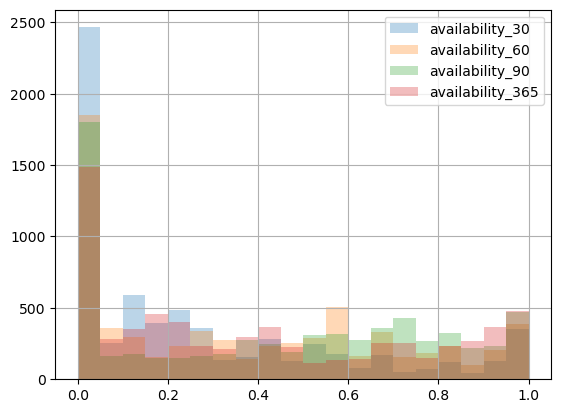

In [10]:
# Check the NA values in columns
print(listings_df['availability_30'].isna().sum())
print(listings_df['availability_60'].isna().sum())
print(listings_df['availability_90'].isna().sum())
print(listings_df['availability_365'].isna().sum())
listings_df_cleaned['availability_30_normed'] = listings_df['availability_30']/30
listings_df_cleaned['availability_60_normed'] = listings_df['availability_60']/60
listings_df_cleaned['availability_90_normed'] = listings_df['availability_90']/90
listings_df_cleaned['availability_365_normed'] = listings_df['availability_365']/365

(listings_df['availability_30']/30).hist(bins=20, alpha=0.3,label='availability_30')
(listings_df['availability_60']/60).hist(bins=20, alpha=0.3,label='availability_60')
(listings_df['availability_90']/90).hist(bins=20, alpha=0.3,label='availability_90')
(listings_df['availability_365']/365).hist(bins=20, alpha=0.3,label='availability_365')
plt.legend()
plt.show()


In [58]:
# Fit the Point-Biserial Correlation model for 'availability_30'
correlation, p_value = scipy.stats.pointbiserialr(listings_df['legal_listing']/30, listings_df['availability_30'])
print(correlation)
print(p_value)

-0.052928564161434974
1.4709020756292807e-05


In [57]:
# Fit the Point-Biserial Correlation model for 'availability_60'
correlation, p_value = scipy.stats.pointbiserialr(listings_df['legal_listing']/60, listings_df['availability_60'])
print(correlation)
print(p_value)

-0.029946080873341732
0.014270966405721817


In [56]:
# Fit the Point-Biserial Correlation model for 'availability_90'
correlation, p_value = scipy.stats.pointbiserialr(listings_df['legal_listing']/90, listings_df['availability_90'])
print(correlation)
print(p_value)

-0.028117638563610835
0.02140892074529158


In [55]:
# Fit the Point-Biserial Correlation model for 'availability_365'
correlation, p_value = scipy.stats.pointbiserialr(listings_df['legal_listing']/365, listings_df['availability_365'])
print(correlation)
print(p_value)

-0.17020479061535984
1.0728575606541276e-44


6.**PRICE** = ['price']

In [25]:
# 6.PRICE 

# Convert price to a float variable (already done before, so I put a '#' ahead)
listings_df['price'] = listings_df['price'].str.replace('$', '').str.replace(',', '').astype(float)

# Concat PRICE column into cleaned_listing
listings_df_cleaned['price'] = listings_df['price']

# Normalization of prices, I suggest the Z-score Normalization because 
# the lower price and higher price could have opposite indication about the legality.
scaler = StandardScaler()
listings_df_cleaned['price_normed'] = scaler.fit_transform(listings_df[['price']])

7.**hosts' asset** = ['calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']

In [26]:
# Concat new one
hosts_asset_list = ['calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
                    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']
listings_df_cleaned[hosts_asset_list] = listings_df[hosts_asset_list]

In [27]:
# Check the amount of observations containing NAs
listings_df_cleaned_dropna = listings_df_cleaned.dropna()

# Question is after delecting all listings with NAs, it turns out 4313 rows from the original 6695 rows. Is that acceptable for our analysis?

In [11]:
# Save the dataframe to a new csv file
#listings_df.to_csv(os.path.join('data', 'yvr_listing_data_cleaned.csv'), index=False)